In [1]:

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import random
import pickle

RGB_img=True
#crop_and_resize = [128,128,32,32] # crop_width, crop_height, resize_width, resize_height
crop_and_resize = [128,128,64,64] # crop_width, crop_height, resize_width, resize_height
crop_width = crop_and_resize[0]
crop_height = crop_and_resize[1]
resize_width = crop_and_resize[2]
resize_height = crop_and_resize[3]
sample_size=10000
Ramdom_seed_for_sampling=1005


In [2]:
file_path1 = os.getcwd()+'/data_to_use/concised_U.pkl'
file_path2 = os.getcwd()+'/data_to_use/concised_S.pkl'
file_path3 = os.getcwd()+'/data_to_use/concised_V.pkl'

with open(file_path1, "rb") as f1:
    concised_U = pickle.load(f1)
with open(file_path2, "rb") as f2:
    concised_S = pickle.load(f2)
with open(file_path3, "rb") as f3:
    concised_V = pickle.load(f3)


In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual,Layout
import ipywidgets as widgets
import time

class mvp:

    def __init__(self, start_sample, U_matrix, S_matrix, V_matrix, modes_to_tune):

        self.U_ModeWise_MaxLoad = U_matrix.max(axis=0, keepdims=0)
        self.U_ModeWise_MinLoad = U_matrix.min(axis=0, keepdims=0)
        self.U_ModeWise_MeanLoad = U_matrix.mean(axis=0, keepdims=0)
        self.U_ModeWise_MaxMinMidLoad = (self.U_ModeWise_MaxLoad - self.U_ModeWise_MinLoad) / 2 + self.U_ModeWise_MinLoad
        self.U_ModeWise_MaxMinMidLoad = (self.U_ModeWise_MaxLoad - self.U_ModeWise_MinLoad) / 2 + self.U_ModeWise_MinLoad
        
        Normalized_U = 2*(U_matrix-self.U_ModeWise_MaxMinMidLoad)/(self.U_ModeWise_MaxLoad-self.U_ModeWise_MinLoad)
        Normalized_U_binned=np.around(Normalized_U, decimals=2, out=None)
        
        self.U_matrix_to_use = Normalized_U_binned
        self.S_matrix_to_use = S_matrix
        self.V_matrix_to_use = V_matrix
        self.modes_to_tune_list = modes_to_tune
        self.plot_reshape=(64, 64, 3)
        self.initial_sample1 = start_sample

        self.customized_U1_sample_original = self.U_matrix_to_use[self.initial_sample1].copy()
        self.customized_U1_sample          = self.U_matrix_to_use[self.initial_sample1,:].copy()

        # define widgets
        self.sample_seed_input1=widgets.IntText(value=900,description='sample ID',disabled=False,layout=Layout(width='50%'))
        self.resample_button = widgets.Button(description='resample',disabled=False,layout=Layout(width='25%'))
        self.reset_button = widgets.Button(description='reset',layout=Layout(width='25%'))
        self.slider_tuning_without_updating_the_plot = widgets.ToggleButton(value=False)
        self.Data_type = 'CelebA'
        
        self.sliders1=[]
        self.PC_thumbnails_list = []

        for mode in self.modes_to_tune_list:
            self.slider1 = widgets.FloatSlider(min=-1.5, max=1.5, step=0.01, value=self.U_matrix_to_use[self.initial_sample1, mode], description = f'mode{mode}', continuous_update = False, layout = Layout(min_width = '300px', align_self="stretch"))
            self.PC_thumbnail_output = widgets.Output(layout = Layout(height = '80px',align_self = "center",margin = ('0px 0px 0px 0px'),padding = ('0px 0px 0px 0px')))
            self.sliders1.append(self.slider1)
            self.PC_thumbnails_list.append(self.PC_thumbnail_output)

        self.slider_to_mode_dictionary=dict(zip(self.sliders1,self.modes_to_tune_list))
        self.PC_thumbnail_to_mode_dictionary = dict(zip(self.PC_thumbnails_list, self.modes_to_tune_list))


        ## put thins together
        self.sample1_static_output = widgets.Output()
        self.sample1_dynamic_output = widgets.Output()
        mode_control_list=[]
        for _, (slider1, thumbnail) in enumerate(zip(self.PC_thumbnails_list, self.sliders1)):
            mode_control_list.append(widgets.HBox([slider1,thumbnail],layout = Layout(align_items = 'stretch')))
        self.mode_control_box = widgets.VBox(mode_control_list)

        self.image_output_box = widgets.HBox([self.sample1_dynamic_output,self.sample1_static_output])
        #self.resample_box = widgets.HBox([self.sample_seed_input1, self.resample_button])
        self.resample_box = widgets.HBox([self.resample_button])## hide sample ID
        self.final_GUI = widgets.VBox([self.image_output_box, self.resample_box, self.reset_button, self.mode_control_box])

        # define button behavoir
        for slider in self.sliders1:
            slider.observe(self.slider_to_plot, names='value')
        self.reset_button.on_click(self.reset1)
        self.resample_button.on_click(self.resample)
        self.sample_seed_input1.observe(self.reset1, names='value')

        self.GUI_initiation()

    def GUI_initiation(self):
        self.plot_static1(self.customized_U1_sample_original)
        self.plot_dynamic1(self.customized_U1_sample)
        self.plot_PC_thumbnail()

        
    def display_GUI(self):
        display(self.final_GUI)

    def image_recon_from_nob(self, customized_U):
        #customized_U_pretreatment=customized_U*(U_ModeWise_MaxLoad-U_ModeWise_MinLoad)/2+U_ModeWise_MeanLoad
        customized_U_pretreatment=customized_U*(self.U_ModeWise_MaxLoad-self.U_ModeWise_MinLoad)/2+self.U_ModeWise_MaxMinMidLoad
        image_generated = customized_U_pretreatment @ np.diag(self.S_matrix_to_use) @ self.V_matrix_to_use.T
        image_generated = (image_generated-np.min(image_generated))/(np.max(image_generated)-np.min(image_generated))
        return image_generated
    
    def plot_dynamic1(self, customized_U1_sample):
        with self.sample1_dynamic_output:
            self.sample1_dynamic_output.clear_output(wait=True)
            fig, axes = plt.subplots(1,1,figsize=(4,5))
            divnorm=colors.TwoSlopeNorm(vcenter=0)
            Reshaped_toplot = np.ndarray.reshape(self.image_recon_from_nob(customized_U1_sample), self.plot_reshape, order='C')
            axes.imshow(Reshaped_toplot, cmap="bwr", norm=divnorm)
            axes.set_yticks([])
            axes.set_xticks([])
            fig.tight_layout()
            plt.show(block=False)
            plt.close()

    def plot_static1(self, customized_U1_sample_original):
        with self.sample1_static_output:
            self.sample1_static_output.clear_output(wait=True)
            fig, axes = plt.subplots(1,1,figsize=(4,5))
            divnorm=colors.TwoSlopeNorm(vcenter=0)
            Reshaped_toplot = np.ndarray.reshape(self.image_recon_from_nob(customized_U1_sample_original), self.plot_reshape, order='C')
            axes.imshow(Reshaped_toplot, cmap="bwr", norm=divnorm)
            axes.set_yticks([])
            axes.set_xticks([])
            fig.tight_layout()
            plt.show(block=False)
            plt.close()

    def plot_PC_thumbnail(self):
        for thumbnail in self.PC_thumbnails_list:
            mode = self.PC_thumbnail_to_mode_dictionary[thumbnail]
            with thumbnail:
                thumbnail.clear_output(wait=True)
                fig, ax = plt.subplots(1,1,figsize=(0.95,0.95))
                if self.Data_type == 'MNIST':
                    Reshaped_toplot = np.ndarray.reshape(self.V_matrix_to_use[:, mode], self.plot_reshape, order='C')
                    divnorm = colors.TwoSlopeNorm(vcenter=0)
                    ax.imshow(np.array(Reshaped_toplot), cmap="bwr", norm = divnorm)
                elif self.Data_type == 'CelebA':
                    Reshaped_toplot=np.ndarray.reshape(self.V_matrix_to_use[:, mode], self.plot_reshape, order='C')
                    image_norm = (Reshaped_toplot-np.min(Reshaped_toplot))/(np.max(Reshaped_toplot)-np.min(Reshaped_toplot))
                    ax.imshow(np.array(image_norm), cmap="bwr",vmin=0,vmax=1)
                ax.set_yticks([])
                ax.set_xticks([])
                fig.tight_layout()
                plt.show(block=False)
                plt.close()

    def slider_to_plot(self, change):
        input_slider=change.owner
        input_value=change.new
        input_mode = self.slider_to_mode_dictionary[input_slider]
        self.customized_U1_sample[input_mode] = input_value
        if self.slider_tuning_without_updating_the_plot.value == False:
            self.plot_dynamic1(self.customized_U1_sample)
        else:
            self.slider_tuning_without_updating_the_plot.value = False

    def initialize_sliders1(self):
        sample1 = self.sample_seed_input1.value
        self.customized_U1_sample = self.U_matrix_to_use[sample1,:].copy()

        for idx, slider1 in enumerate(self.sliders1):
            mode = self.slider_to_mode_dictionary[slider1]
            if idx == len(self.sliders1)-1:
                self.slider_tuning_without_updating_the_plot.value = False
            else:
                self.slider_tuning_without_updating_the_plot.value = True
            slider1.value = self.customized_U1_sample[mode]
        
        self.customized_U1_sample_original = self.U_matrix_to_use[sample1,:].copy()
        self.plot_static1(self.customized_U1_sample_original)
        self.plot_dynamic1(self.customized_U1_sample)

    def reset1(self, b):
        self.initialize_sliders1()

    def resample(self,change):
        self.sample_seed_input1.value = random.sample(range(self.U_matrix_to_use.shape[0]), 1)[0]
        self.initialize_sliders1()


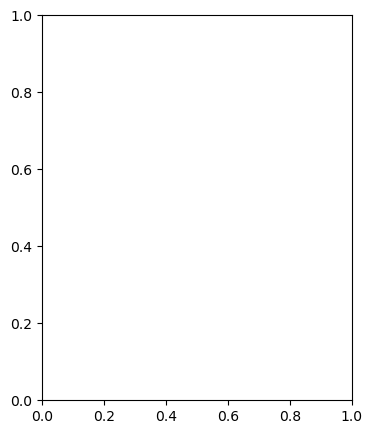

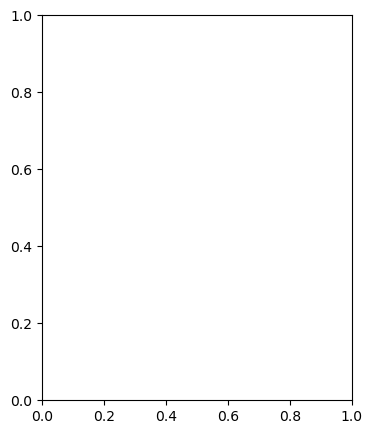

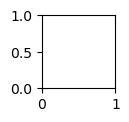

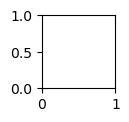

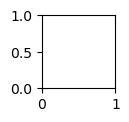

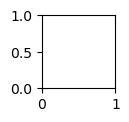

In [4]:

U_matrix_to_use = concised_U
S_matrix_to_use = concised_S
V_matrix_to_use = concised_V
start_sample = 0
modes_to_tune=[7, 8, 9, 33]

mvp_1 = mvp(start_sample, U_matrix_to_use, S_matrix_to_use, V_matrix_to_use, modes_to_tune)
mvp_1.display_GUI()